### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn

### Import Dataset

In [2]:
dataset = pd.read_csv("C:\\Users\\seven\\Downloads\\UberDataset.csv")
dataset.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [3]:
dataset.shape

(1156, 7)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


### Data Processing/Cleaning

##### Replace null values in PURPOSE column with a NOT keyword.

In [5]:
dataset.loc[:, 'PURPOSE'] = dataset['PURPOSE'].fillna("NOT")

##### Changing the START_DATE and END_DATE to the date_time format to be used for analysis

In [6]:
dataset['START_DATE'] = pd.to_datetime(dataset['START_DATE'],
                                       errors='coerce')
dataset['END_DATE'] = pd.to_datetime(dataset['END_DATE'],
                                     errors='coerce')

##### Splitting the START_DATE to date and time column and then converting the time into four different categories- Morning, Afternoon, Evening, Night

In [7]:
dataset['date'] = pd.DatetimeIndex(dataset['START_DATE']).date
dataset['time'] = pd.DatetimeIndex(dataset['START_DATE']).hour

# changing into categories of day and night
dataset['day-night'] = pd.cut(x=dataset['time'],
                              bins = [0,10,15,19,24],
                              labels = ['Morning', 'Afternoon', 'Evening', 'Night'])

##### Dropping rows with null values

In [8]:
dataset.dropna(inplace=True)

##### Dropping duplicate rows

In [9]:
dataset.drop_duplicates(inplace=True)

### Data Visualization

##### Comparing all columns and check the unique values of the dataset

In [10]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)

unique_values = {}
for col in object_cols:
    unique_values[col] = dataset[col].unique().size
unique_values

{'CATEGORY': 2, 'START': 108, 'STOP': 112, 'PURPOSE': 7, 'date': 113}

##### Create countplots for the CATEGORY and PURPOSE columns

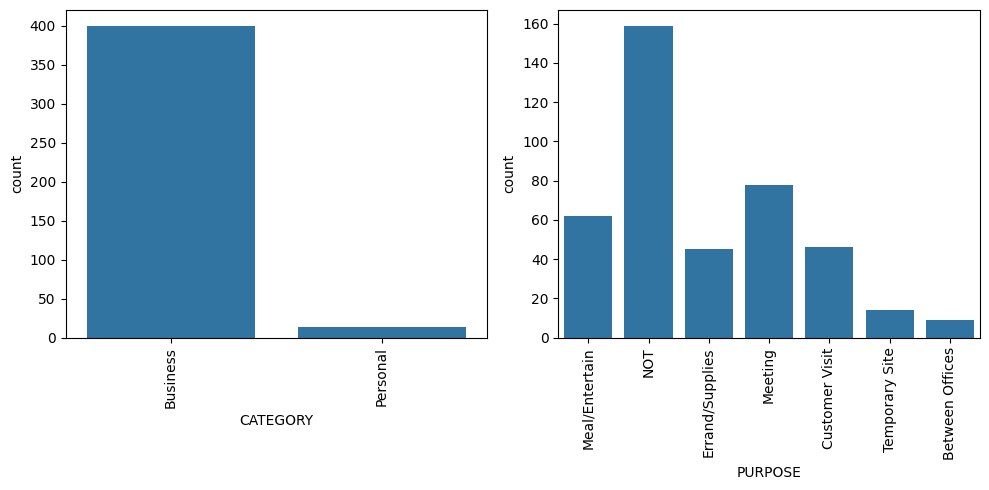

In [11]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.countplot(x='CATEGORY', data=dataset)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.countplot(x='PURPOSE', data=dataset)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


##### Create countplot for the separated time column

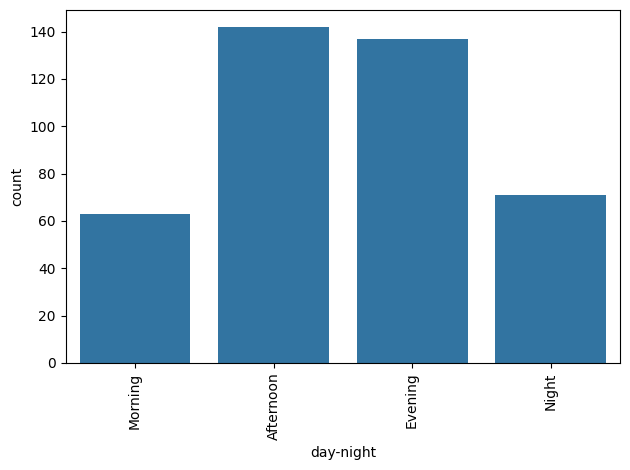

In [12]:
sns.countplot(x='day-night', data=dataset)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### Comparing the two different categories along with the PURPOSE of the user

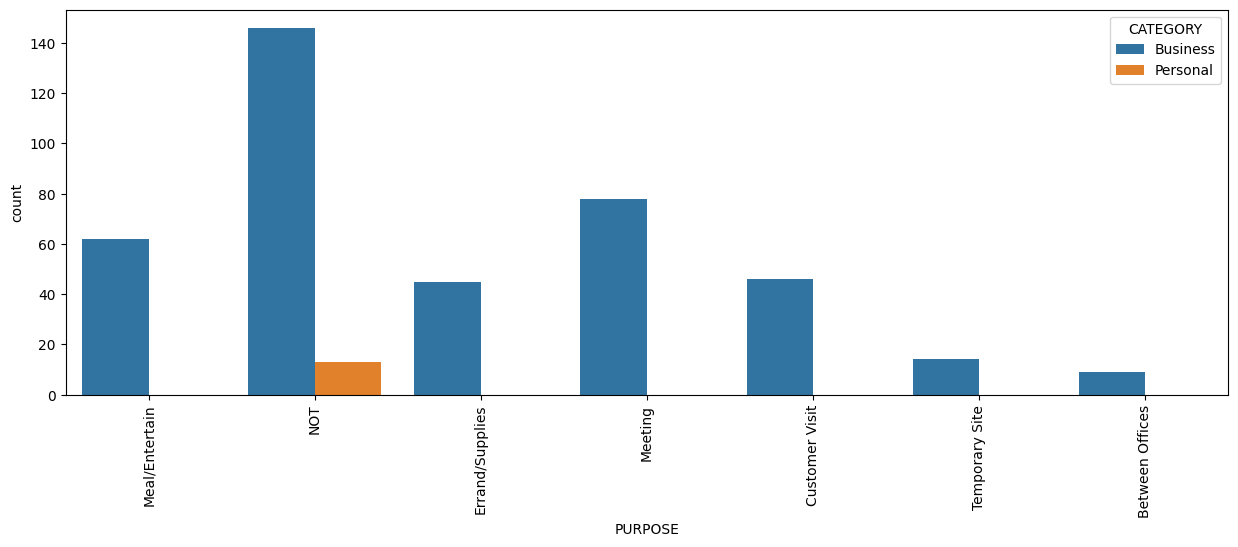

In [13]:
plt.figure(figsize=(15,5))
sns.countplot(data=dataset, x= 'PURPOSE', hue= 'CATEGORY')
plt.xticks(rotation=90)
plt.show()

### Insights from the above countplots:

##### Most of the rides are booked for business purposes

##### Most of the people book rides for Meetings and Meal/Entertain purposes

##### Most of the rides are booked in the time duration of 10am to 5pm (Afternoon)

### CATEGORY and PURPOSE are the most important columns in the dataset. Diving deeper into analysis

In [14]:
from sklearn.preprocessing import OneHotEncoder
object_cols = ['CATEGORY', 'PURPOSE']
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(dataset[object_cols]))
OH_cols.index = dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = dataset.drop(object_cols, axis=1)
dataset = pd.concat([df_final, OH_cols], axis=1)

##### Find the correlation between the columns using a heatmap

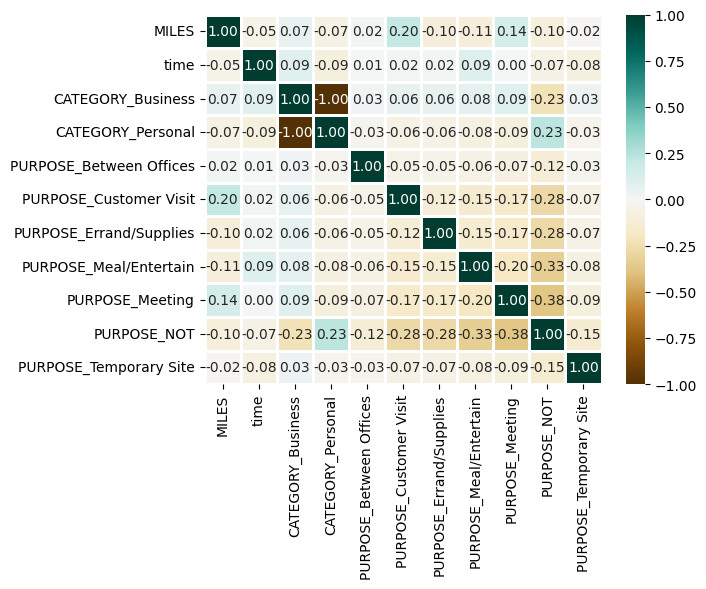

In [15]:
numeric_dataset = dataset.select_dtypes(include=['number'])

sns.heatmap(numeric_dataset.corr(),
            cmap='BrBG',
            fmt='.2f',
            linewidths=2,
            annot=True);

### Insights from heatmap:

##### Business and Personal Category are highly and negatively correlated. Insight has been proven earlier, but this plot justifies the previous conclusions

##### There is not much correlation between Business and Personal purposes.

### Visualizing the monthly data

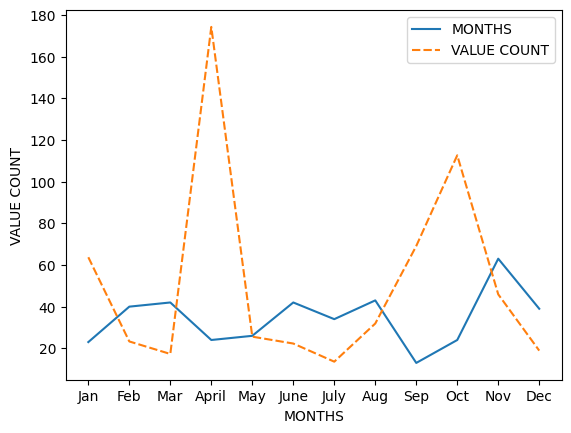

In [16]:
dataset['MONTH'] = pd.DatetimeIndex(dataset['START_DATE']).month
month_label = {1.0: 'Jan', 2.0: 'Feb', 3.0: 'Mar', 4.0: 'April',
               5.0: 'May', 6.0: 'June', 7.0: 'July', 8.0: 'Aug',
               9.0: 'Sep', 10.0: 'Oct', 11.0: 'Nov', 12.0: 'Dec'}
dataset["MONTH"] = dataset.MONTH.map(month_label)

mon = dataset.MONTH.value_counts(sort=False)

# Month total rides count vs Month ride max count
df = pd.DataFrame({"MONTHS": mon.values,
                   "VALUE COUNT": dataset.groupby('MONTH',
                                                  sort=False)['MILES'].max()})
p = sns.lineplot(data=df)
p.set(xlabel="MONTHS", ylabel= "VALUE COUNT");

### Insights from linegraph

##### The counts are irregular

##### The winter months (Nov, Dec and Jan) are significantly less

### Visualizing the day of week figures

In [17]:
dataset['DAY'] = dataset.START_DATE.dt.weekday
day_label = {
    0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thus', 4: 'Fri', 5: 'Sat', 6: 'Sun'
}
dataset['DAY'] = dataset['DAY'].map(day_label)

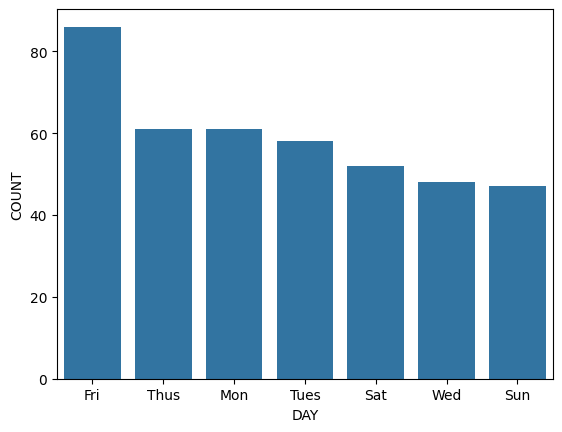

In [18]:
day_label = dataset.DAY.value_counts()
sns.barplot(x=day_label.index, y=day_label);
plt.xlabel('DAY')
plt.ylabel('COUNT');

### Analyzing the MILES column with a boxplot

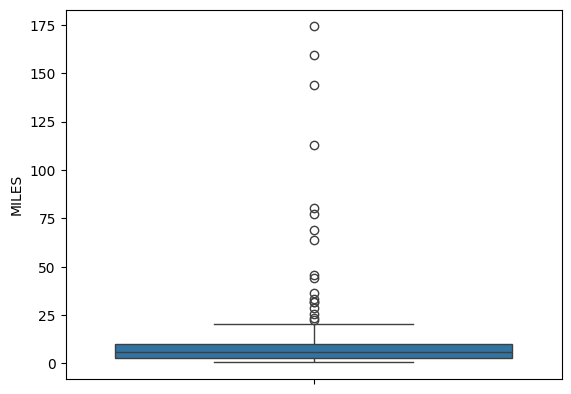

In [20]:
sns.boxplot(dataset['MILES']);

##### Since there are four outliers in the >100 mile range, eliminating those as they are not useful

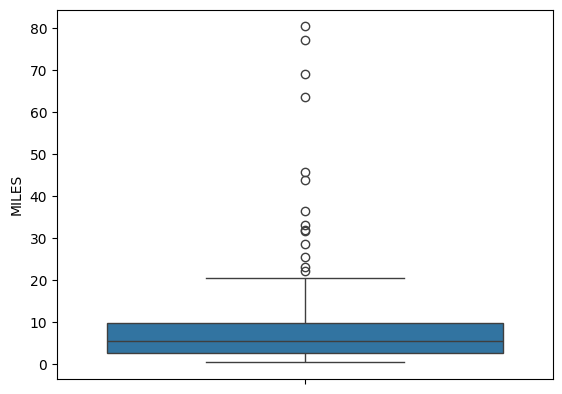

In [22]:
sns.boxplot(dataset[dataset['MILES']<100]['MILES']);

##### Better, but mot much clarity other than the majority of rides are between 0 and 10 miles. Trying a distribution plot graph (displot)

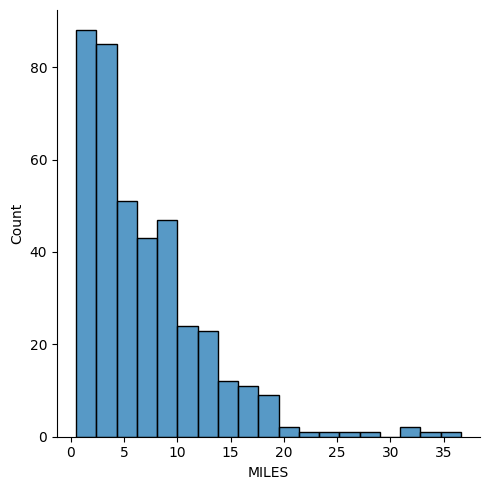

In [27]:
sns.displot(dataset[dataset['MILES']<40]['MILES']);

### Insights from above graphs:

##### Most of the rides booked are for the distance of 4 to 5 miles

##### Majority of rides are under 20 miles

##### Anything over 20 miles is barely significant